In this notebook, I use Random Forest to determine the features that are important in explaining the observed value of gini and gamma.

# Staging

pip install rfpimp

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rfpimp import *
import networkx as nx

In [2]:
sns.set(style="darkgrid")

# Import and Prep Data

In [3]:
# Geometry of stations and lines
stations_gdf = gpd.read_file('outputs/stn_data/geometry/stations_gdf.gpkg')
lines_gdf = gpd.read_file('outputs/stn_data/geometry/lines_gdf.gpkg')

bng_crs = stations_gdf.crs

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
# Draw buffer around stations
stations_buffer = stations_gdf.copy()
stations_buffer['buffer'] = stations_gdf.geometry.buffer(1000)
stations_buffer.set_geometry(col='buffer', drop=True, inplace=True)

buffer_area = stations_buffer.geometry.area.values[0]/1000000

In [5]:
# Concentration data
stn_conc = pd.read_csv('outputs/stn_data/concentration/stn_conc_throughput.csv')

## Land use data

In [6]:
# Local authorities 
# https://geoportal.statistics.gov.uk/datasets/fef73aeaf13c417dadf2fc99abcf8eef/explore?layer=0&location=51.640057%2C-0.511728%2C10.50
# Accessed: 21 July 2022

la_gdf = gpd.read_file('data/features/lad_boundaries.zip!Local_Authority_Districts_(December_2018)_Boundaries_UK_BFC.shp')
la_gdf = la_gdf[['lad18cd', 'lad18nm', 'geometry']]

In [7]:
# Land use data
# https://www.gov.uk/government/statistical-data-sets/live-tables-on-land-use
# Accessed: 21 July 2022

land_use = pd.read_excel('data/features/land_use_2018.xlsx',
                         sheet_name='Processed')

In [8]:
# Merge land use data to gdf
la_land_gdf = la_gdf.merge(land_use, left_on='lad18nm', right_on='Local Authority Name')

In [9]:
# Find intersection between buffer and land use gdf
intersect_data = gpd.overlay(stations_buffer, la_land_gdf)

In [10]:
# Get land use categories
land_use_cat = land_use.columns[2:]

In [11]:
stn_land_list = []

# Find percentage of land use surrounding each stations
for stn in stations_gdf['name'].tolist():

    # Get station's land use data
    data_temp = intersect_data[intersect_data['name'] == stn]

    # Compute area of intersections
    data_temp['area'] = data_temp.geometry.area

    # Convert area into ratio
    data_temp['area'] = data_temp['area']/sum(data_temp['area'])

    # Collect land use area and convert to percentage
    land_use_list = [sum(data_temp['area']*data_temp[i]) for i in land_use_cat]
    tot_area = sum(land_use_list)
    land_use_pct = [j/tot_area for j in land_use_list]
    stn_land_list.append(land_use_pct)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [12]:
# Create dataframe to hold value of explanatory variables
exp_var = pd.DataFrame(stn_land_list,
                       columns=land_use_cat,
                       index=stations_gdf['name'].tolist())

In [13]:
# Keep only relevant land use
exp_var = exp_var[['Community Buildings', 'Leisure and recreational buildings',
                   'Industry', 'Offices', 'Retail', 'Storage and Warehousing',
                   'Institutional and Communal Accommodation', 'Residential']]

In [14]:
# Rename land use categories
exp_var.rename({'Community Buildings': 'community_bldg',
                'Leisure and recreational buildings': 'leisure_recreational_bldg',
                'Industry': 'industry',
                'Offices': 'offices',
                'Retail': 'retail', 
                'Storage and Warehousing': 'storage_and_warehousing',
                'Institutional and Communal Accommodation': 'instit_communal_accom',
                'Residential': 'residential'},
               axis=1, inplace=True)

## Location

In [15]:
inner_london = ['Camden', 'Hackney', 'Hammersmith and Fulham',
                'Islington', 'Kensington and Chelsea', 'Lambeth', 
                'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth',
                'Westminster', 'City of London', 'Haringey', 'Newham']

inner_gdf = la_gdf[la_gdf['lad18nm'].isin(inner_london)]
inner_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=inner_gdf.unary_union, crs='epsg:27700')).\
    rename(columns={0: 'inner'})
inner_gdf = inner_gdf.set_geometry('inner')

In [16]:
# Stations in Inner London
inner_stn = gpd.sjoin(stations_gdf, inner_gdf,
                      op='intersects', how='inner')

In [17]:
# Merge to explanatory variables
exp_var['inner'] = 0
exp_var.loc[exp_var.index.isin(inner_stn['name']), 'inner'] = 1

In [18]:
# Central Activity Zone
# https://data.london.gov.uk/dataset/central_activities_zone
# Accessed: 21 July 2022

caz_gdf = gpd.read_file('data/features/central_activities_zone.gpkg')
caz_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=caz_gdf.unary_union, crs='epsg:27700')).\
    rename(columns={0: 'caz'})
caz_gdf = caz_gdf.set_geometry('caz')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [19]:
# Stations in CAZ
caz_stn = gpd.sjoin(stations_gdf, caz_gdf,
                    op='intersects', how='inner')

In [20]:
# Merge to explanatory variables
exp_var['caz'] = 0
exp_var.loc[exp_var.index.isin(caz_stn['name']), 'caz'] = 1

## Population Density

In [21]:
# LSOA boundaries
# https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2011-boundaries-generalised-clipped-bgc-ew-v3/explore?location=52.883172%2C-5.454967%2C9.99
# Accessed: 21 July 2022

lsoa_gdf = gpd.read_file('data/features/lsoa_boundaries.zip!Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.shp')
lsoa_gdf = lsoa_gdf[['LSOA11CD', 'LSOA11NM', 'geometry']]

In [22]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareapopulationdensity
# Accessed: 21 July 2022

pop_density = pd.read_excel('data/features/lsoa_pop_density_mid2020.xlsx',
                            sheet_name='Mid-2020 Population Density', skiprows=4)

In [23]:
# Merge population density to gdf
lsoa_pop_gdf = lsoa_gdf.merge(pop_density[['LSOA Code', 'LSOA Name', 'People per Sq Km']],
                              left_on='LSOA11CD', right_on='LSOA Code')

In [24]:
# Find intersection between buffer and land use gdf
intersect_data = gpd.overlay(stations_buffer, lsoa_pop_gdf)

In [25]:
stn_pop_list = []

# Find population density surrounding each stations
for stn in stations_gdf['name'].tolist():

    # Get station's land use data
    data_temp = intersect_data[intersect_data['name'] == stn]

    # Compute area of intersections
    data_temp['area'] = data_temp.geometry.area

    # Convert area into ratio
    data_temp['area'] = data_temp['area']/sum(data_temp['area'])

    # Compute average population density
    stn_pop_list.append(sum(data_temp['area']/sum(data_temp['area'])*\
                            data_temp['People per Sq Km']))

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [26]:
# Merge to explanatory variables
exp_var['pop_density'] = stn_pop_list

## Jobs density

In [27]:
# https://www.nomisweb.co.uk/query/construct/summary.asp?mode=construct&dataset=189&version=0
# Accessed: 21 July 2022

job_density = pd.read_csv('data/features/lsoa_jobs_count_2020.csv')

In [28]:
# Total number of jobs in each LSOA
job_density['total']=job_density.iloc[:, 2:].sum(axis=1)
job_cnt = job_density.groupby('mnemonic')['total'].sum()

In [29]:
# Merge jobs density to gdf
lsoa_jobs_gdf = lsoa_gdf.merge(job_cnt,
                               left_on='LSOA11CD', right_on='mnemonic')

In [30]:
# Convert to jobs per unit area
lsoa_jobs_gdf['jobs_density'] = lsoa_jobs_gdf['total']/\
    (lsoa_jobs_gdf.geometry.area/1000000)

In [31]:
# Find intersection between buffer and jobs density gdf
intersect_data = gpd.overlay(stations_buffer, lsoa_jobs_gdf)

In [32]:
stn_job_list = []

# Find jobs density surrounding each stations
for stn in stations_gdf['name'].tolist():

    # Get station's land use data
    data_temp = intersect_data[intersect_data['name'] == stn]

    # Compute area of intersections
    data_temp['area'] = data_temp.geometry.area

    # Convert area into ratio
    data_temp['area'] = data_temp['area']/sum(data_temp['area'])

    # Compute average population density
    stn_job_list.append(sum(data_temp['area']/sum(data_temp['area'])*\
                            data_temp['jobs_density']))

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [33]:
# Merge to explanatory variables
exp_var['jobs_density'] = stn_job_list

## Density of public transport access points

In [34]:
# https://www.data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan
# Accessed: 21 July 2021
naptan = pd.read_csv('data/features/naptan.csv')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,2,6,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
# Create gdf
naptan_gdf =\
    gpd.GeoDataFrame(naptan,
                     geometry=[Point(x, y) for x, y
                               in zip(naptan.Longitude, naptan.Latitude)],
                     crs='EPSG:4326')
naptan_gdf.to_crs(bng_crs, inplace=True)

In [36]:
stn_naptan_list = []

# Find number of busstops surrounding each stations
for stn in stations_gdf['name'].tolist():

    # Get station's buffer
    data_temp = stations_buffer[stations_buffer['name'] == stn]

    # Find stations within buffer
    data_temp = gpd.sjoin(naptan_gdf, data_temp,
                          op='intersects', how='inner')

    # Count number of stations
    stn_naptan_list.append(len(data_temp)/buffer_area)

In [37]:
# Merge to explanatory variables
exp_var['naptan_density'] = stn_naptan_list

## Network structure

In [38]:
G = nx.read_graphml("outputs/stn_data/geometry/network_graph")

In [39]:
# Degree centrality
deg_cent = pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').\
    rename({0: 'deg_centrality'}, axis=1)

In [40]:
exp_var = exp_var.merge(deg_cent, left_index=True, right_index=True)

In [41]:
# Betweenness centrality
btwn_cent = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').\
    rename({0: 'btwn_centrality'},axis=1)

In [42]:
exp_var = exp_var.merge(btwn_cent, left_index=True, right_index=True)

## Check Explanatory Variables

In [43]:
exp_var.head()

,community_bldg,leisure_recreational_bldg,industry,offices,retail,storage_and_warehousing,instit_communal_accom,residential,inner,caz,pop_density,jobs_density,naptan_density,deg_centrality,btwn_centrality
Acton Town,0.045090,0.000274,0.003326,0.008897,0.011962,0.009192,0.001843,0.105412,0,0,6892.901620,12252.574201,2.231753,0.015152,0.113110
Aldgate,0.055811,0.001169,0.006729,0.022270,0.020554,0.003924,0.002926,0.127112,1,1,11821.242915,205097.660671,13.390515,0.007576,0.000291
Aldgate East,0.056810,0.000869,0.007036,0.020401,0.017154,0.004104,0.002834,0.129033,1,1,14099.574178,152530.824175,9.883475,0.011364,0.010971
Alperton,0.053071,0.001176,0.007776,0.006364,0.009463,0.015457,0.001669,0.124641,0,0,7951.186671,7080.355819,0.956465,0.007576,0.031887
Amersham,0.009448,0.000012,0.000060,0.001036,0.000729,0.000050,0.000259,0.017046,0,0,2040.327625,2178.407995,14.028159,0.003788,0.000000


In [44]:
exp_var.describe()

,community_bldg,leisure_recreational_bldg,industry,offices,retail,storage_and_warehousing,instit_communal_accom,residential,inner,caz,pop_density,jobs_density,naptan_density,deg_centrality,btwn_centrality
count,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000
mean,0.049194,0.001006,0.003782,0.015093,0.011708,0.004341,0.002144,0.125371,0.505660,0.188679,9366.134525,38040.787893,4.287852,0.008748,0.048949
std,0.014218,0.001054,0.005652,0.016102,0.007383,0.004712,0.001486,0.045295,0.500914,0.391994,4923.245236,69678.047460,4.555781,0.003764,0.062132
min,0.006364,0.000012,0.000060,0.000523,0.000729,0.000050,0.000178,0.010713,0.000000,0.000000,150.717917,184.912463,0.637644,0.003788,0.000000
25%,0.041403,0.000209,0.000961,0.003107,0.005463,0.000935,0.001129,0.101635,0.000000,0.000000,5387.099821,3630.472798,1.275287,0.007576,0.007576
50%,0.049303,0.000580,0.001913,0.008897,0.010640,0.002411,0.001677,0.129355,1.000000,0.000000,8487.785248,8716.547679,2.550574,0.007576,0.029957
75%,0.056810,0.001583,0.004816,0.023464,0.015593,0.006124,0.002712,0.160813,1.000000,0.000000,13485.496429,26439.358267,5.101149,0.007576,0.059401
max,0.083282,0.004642,0.041523,0.056986,0.039315,0.018708,0.005932,0.212447,1.000000,1.000000,21457.995867,331635.504597,20.723416,0.026515,0.341007


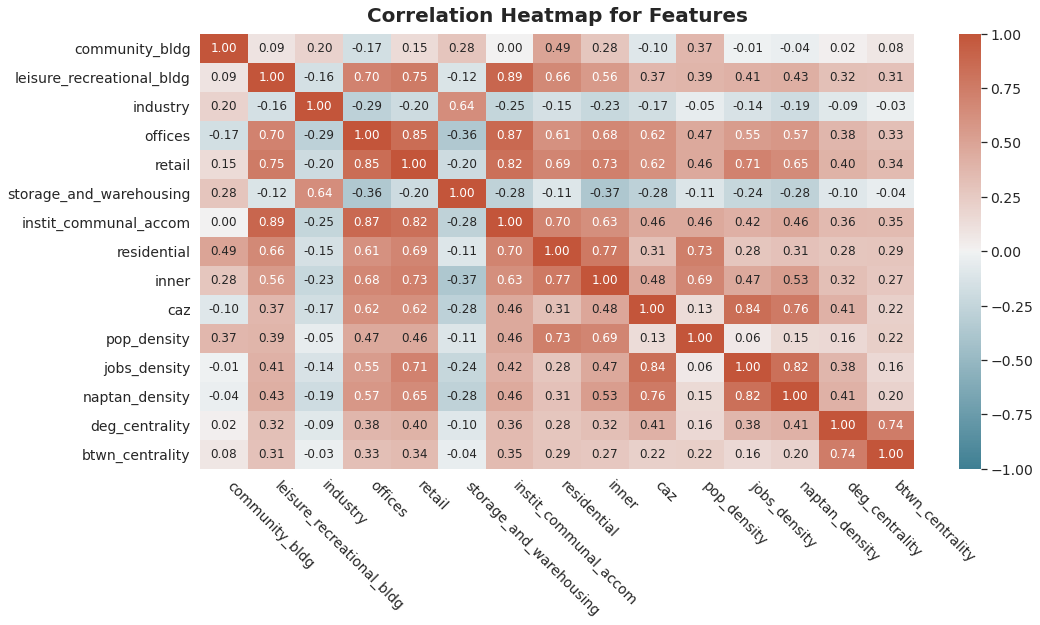

In [45]:
# Visualize correlation in explanatory variables
fig, ax = plt.subplots(1, figsize=(16, 8))
cm = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(exp_var.corr(), vmin=-1, vmax=1, cmap=cm,
            annot=True, fmt='.2f', ax=ax)
plt.xticks(rotation=315, ha="left")
ax.set_title('Correlation Heatmap for Features',
             fontdict={'fontsize': 20, 'weight': 'bold'}, pad=12);

ax.tick_params(labelsize=14);
ax.figure.axes[-1].tick_params(labelsize=14);


#fig.savefig('outputs/figures/feature_selection/correlation_heatmap.png',
#            bbox_inches="tight")

# Feature Selection

## Create Functions and Set Common Parameters

In [46]:
# Create function to use Random Forest to select variables
def rf_select(df_exp_var, df_dep_var, rf_model, n_run):

    '''
    Use Random Forest to select variables by removing features with 
    least importance sequentially

    :param df_exp_var: df of explanatory variables
    :param df_dep_var: df of dependent variable
    :param rf_model: random forest model
    :param n_run: number of runs for each variable
    :return ft_impt: df of importance and rank for each run
    :return perf: df of R2 score and mse for each run
    :return ft_rm: df of mean R2 and variables removed
    '''

    # Copy df
    dep_var = df_dep_var.copy()
    exp_var_rm = df_exp_var.copy()

    # Create lists to hold values
    n_features_rm_list = []
    run_list = []
    feature_list = []
    imp_list = []
    rank_list = []
    r2_list = []
    mse_list = []
    feature_rm_list = []
    r2_mean = []
    mse_mean = []

    # Number of features
    n_feature = len(exp_var_rm.columns)

    for n_remove in range(n_feature-1):
        print(f"{n_remove} variables removed")
        
        # Note that all the results reported in the dissertation have been uploaded on the output folders.
        # This 'continue' command is included here to bypass the RF modelling,
        # so that subsequent codes can reproduce the results reported in the dissertation.
        # It can be removed if the interest is in re-using the code for other purposes.
        continue

        # Create list to hold values for current number of features
        n_features_rm_curr = []
        run_curr = []
        feature_curr = []
        imp_curr = []
        rank_curr = []
        r2_curr = []
        mse_curr = []

        # Iterate training
        for run in range(n_run):

            # Split training and testing dataset
            train_x, test_x, train_y, test_y =\
                train_test_split(exp_var_rm, dep_var)

            # Fit random forest
            rf_model.fit(train_x, train_y);

            # Get importance of features and R2 value
            imp = dropcol_importances(rf_model, train_x, train_y)
            n_features_rm_curr = n_features_rm_curr + [n_remove]*len(imp.index)
            run_curr = run_curr + [run]*len(imp.index)
            feature_curr = feature_curr + list(imp.index)
            imp_curr = imp_curr + list(imp['Importance'])
            rank_curr = rank_curr + list(range(1, len(imp.index)+1))
            r2_curr.append(rf_model.score(X=test_x, y=test_y))
            mse_curr.append(mean_squared_error(test_y, rf_model.predict(test_x)))

        # Append lists to store
        n_features_rm_list = n_features_rm_list + n_features_rm_curr
        run_list = run_list + run_curr
        feature_list = feature_list + feature_curr
        imp_list = imp_list + imp_curr
        rank_list = rank_list + rank_curr
        r2_list = r2_list + r2_curr
        mse_list = mse_list + mse_curr

        # Create dataframe of importance rank
        imp_df = pd.DataFrame(zip(feature_curr, rank_curr),
                              columns=['Feature', 'Rank'])

        # Sort by importance rank of feature
        imp_avg = imp_df.groupby('Feature')\
            .agg(mode=('Rank', lambda x: list(pd.Series.mode(x))[0]),
                 median=('Rank', 'median'),
                 mean=('Rank', 'mean'))
        imp_avg.sort_values(by=['mode', 'median', 'mean'],
                            ascending=True, inplace=True)

        # Get least important feature and drop it
        feature_rm = imp_avg.index[-1]
        feature_rm_list.append(feature_rm)
        exp_var_rm.drop(columns=feature_rm, inplace=True)

        # Compute mean R2 and append
        r2_mean.append(np.mean(r2_curr))
        mse_mean.append(np.mean(mse_curr))

    # Create dataframe and store results
    ft_impt = pd.DataFrame(zip(n_features_rm_list, run_list,
                               feature_list, imp_list, rank_list),
                           columns=['num_features_rm', 'run_num',
                                    'feature', 'importance', 'rank'])

    r2_idx = []
    for i in range(n_feature-1):
        for j in range(n_run):
            r2_idx.append(i)

    perf = pd.DataFrame(zip(r2_idx, r2_list, mse_list),
                        columns=['num_features_rm', 'r2', 'mse'])

    ft_rm = pd.DataFrame(zip(r2_mean, mse_mean, feature_rm_list),
                         columns=['r2_mean', 'mse_mean', 'feature_rm'])

    print('Done!')

    return ft_impt, perf, ft_rm

In [47]:
# Initialize hyperparameters to tune
# Ref: https://wires.onlinelibrary.wiley.com/doi/full/10.1002/widm.1301

# Max features
list_max_features = ['sqrt', 'log2', 'auto', 1/3]

# Max sample
list_max_samples = [0.2, 0.4, 0.6, 0.8, None]

# Min samples in each leaf
list_min_samples_leaf = [1, 5, 10]

grid_hyperparameters = {'max_features': list_max_features,
                        'max_samples': list_max_samples,
                        'min_samples_leaf': list_min_samples_leaf}

In [48]:
# Initialize RF regressor and GridSearchCV
rf = RandomForestRegressor()
cv_rf = model_selection.GridSearchCV(rf, grid_hyperparameters,
                                     scoring='neg_mean_squared_error',
                                     verbose=1, n_jobs=-1)

In [49]:
# Number of trees for each RF
n_trees = 1000

# Number of runs for each feature removed
n_runs = 50

## Feature selection for Gini

In [50]:
measure_curr = 'gini'

In [51]:
# Split training and testing dataset for tuning hyperparameter
train_x, test_x, train_y, test_y =\
    train_test_split(exp_var, stn_conc[measure_curr])

In [52]:
# Run gridsearchCV and get best hyperparameters
cv_rf.fit(train_x, train_y)
cv_gini = cv_rf.best_params_
cv_gini_df = pd.DataFrame.from_dict(cv_gini, orient='index').\
    rename({0: 'best_param'}, axis=1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [53]:
# Set up RF with tuned hyperparameters
rf_gini = RandomForestRegressor(n_estimators=n_trees,
                                max_features=cv_gini['max_features'],
                                max_samples=cv_gini['max_samples'],
                                min_samples_leaf=cv_gini['min_samples_leaf'],
                                n_jobs=-1)

In [54]:
# Note: All the results reported in the dissertation have been uploaded on the output folders
# Therefore, this cell can be skipped, if the interest is in re-producing the results.

# Feature selection
ft_impt_gini, perf_gini, ft_rm_gini =\
    rf_select(df_exp_var=exp_var.copy(),
              df_dep_var=stn_conc[measure_curr],
              rf_model=rf_gini,
              n_run=n_runs)

0 variables removed
1 variables removed
2 variables removed
3 variables removed
4 variables removed
5 variables removed
6 variables removed
7 variables removed
8 variables removed
9 variables removed
10 variables removed
11 variables removed
12 variables removed
13 variables removed
Done!


In [ ]:
# Save results
#cv_gini_df.to_csv('outputs/feature_selection/cv_gini_df.csv')
#ft_impt_gini.to_csv('outputs/feature_selection/ft_impt_gini.csv', index=False)
#perf_gini.to_csv('outputs/feature_selection/perf_gini.csv', index=False)
#ft_rm_gini.to_csv('outputs/feature_selection/ft_rm_gini.csv', index=False)

In [55]:
# Check point - open here
ft_impt_gini = pd.read_csv('outputs/feature_selection/ft_impt_gini.csv')
perf_gini = pd.read_csv('outputs/feature_selection/perf_gini.csv')
ft_rm_gini = pd.read_csv('outputs/feature_selection/ft_rm_gini.csv')

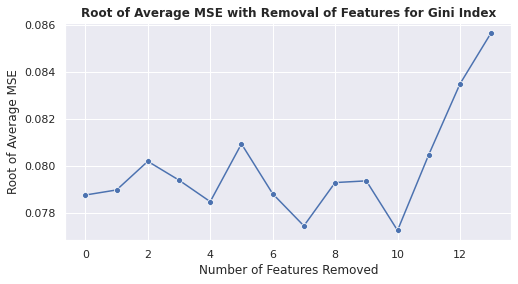

In [56]:
# Plot MSE
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x=ft_rm_gini.index.values, y=np.sqrt(ft_rm_gini['mse_mean']), marker='o')
ax.set(ylabel="Root of Average MSE", xlabel="Number of Features Removed");
ax.set_title("Root of Average MSE with Removal of Features for Gini Index",
             fontsize=12, weight='bold');

#fig.savefig('outputs/figures/feature_selection/gini_results.png',
#            bbox_inches="tight")

In [57]:
best_mse = min(ft_rm_gini['mse_mean'])
n_ft_rm_mse = ft_rm_gini[ft_rm_gini['mse_mean'] == best_mse].index.values[0]
print(f"The best root of average MSE is {np.sqrt(best_mse):.5f}, obtained after removing {n_ft_rm_mse} variables.")

retained_var_gini = list(ft_rm_gini.loc[n_ft_rm_mse:, 'feature_rm']) +\
    list(set(exp_var.columns)-set(ft_rm_gini['feature_rm']))

print(f"The retained variables are: {retained_var_gini}")

The best root of average MSE is 0.07724, obtained after removing 10 variables.
The retained variables are: ['pop_density', 'retail', 'btwn_centrality', 'instit_communal_accom', 'jobs_density']


## Feature Selection For Gamma

In [58]:
measure_curr = 'gamma'

In [59]:
# Split training and testing dataset for tuning hyperparameter
train_x, test_x, train_y, test_y =\
    train_test_split(exp_var, stn_conc[measure_curr])

In [60]:
# Run gridsearchCV and get best hyperparameters
cv_rf.fit(train_x, train_y)
cv_gamma = cv_rf.best_params_
cv_gamma_df = pd.DataFrame.from_dict(cv_gamma, orient='index').\
    rename({0: 'best_param'}, axis=1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [61]:
# Set up RF with tuned hyperparameters
rf_gamma = RandomForestRegressor(n_estimators=n_trees,
                                 max_features=cv_gamma['max_features'],
                                 max_samples=cv_gamma['max_samples'],
                                 min_samples_leaf=cv_gamma['min_samples_leaf'],
                                 n_jobs=-1)

In [62]:
# Note: All the results reported in the dissertation have been uploaded on the output folders
# Therefore, this cell can be skipped, if the interest is in re-producing the results.

# Feature selection
ft_impt_gamma, perf_gamma, ft_rm_gamma =\
    rf_select(df_exp_var=exp_var.copy(),
              df_dep_var=stn_conc[measure_curr],
              rf_model=rf_gamma,
              n_run=n_runs)

0 variables removed
1 variables removed
2 variables removed
3 variables removed
4 variables removed
5 variables removed
6 variables removed
7 variables removed
8 variables removed
9 variables removed
10 variables removed
11 variables removed
12 variables removed
13 variables removed
Done!


In [ ]:
# Save results
#cv_gamma_df.to_csv('outputs/feature_selection/cv_gamma_df.csv')
#ft_impt_gamma.to_csv('outputs/feature_selection/ft_impt_gamma.csv', index=False)
#perf_gamma.to_csv('outputs/feature_selection/perf_gamma.csv', index=False)
#ft_rm_gamma.to_csv('outputs/feature_selection/ft_rm_gamma.csv', index=False)

In [63]:
# Check point - open here
ft_impt_gamma = pd.read_csv('outputs/feature_selection/ft_impt_gamma.csv')
perf_gamma = pd.read_csv('outputs/feature_selection/perf_gamma.csv')
ft_rm_gamma = pd.read_csv('outputs/feature_selection/ft_rm_gamma.csv')

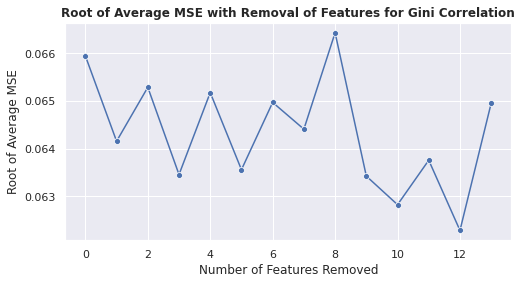

In [64]:
# Plot MSE
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x=ft_rm_gamma.index.values, y=np.sqrt(ft_rm_gamma['mse_mean']), marker='o')
ax.set(ylabel="Root of Average MSE", xlabel="Number of Features Removed");
ax.set_title(fr"Root of Average MSE with Removal of Features for Gini Correlation",
             fontsize=12, weight='bold');

#fig.savefig('outputs/figures/feature_selection/gamma_results.png',
#            bbox_inches="tight")

In [65]:
best_mse = min(ft_rm_gamma['mse_mean'])
n_ft_rm_mse = ft_rm_gamma[ft_rm_gamma['mse_mean'] == best_mse].index.values[0]
print(f"The best root of average MSE is {np.sqrt(best_mse):.5f}, obtained after removing {n_ft_rm_mse} variables.")

retained_var_gamma = list(ft_rm_gamma.loc[n_ft_rm_mse:, 'feature_rm']) +\
    list(set(exp_var.columns)-set(ft_rm_gamma['feature_rm']))

print(f"The retained variables are: {retained_var_gamma}")

The best root of average MSE is 0.06228, obtained after removing 12 variables.
The retained variables are: ['residential', 'jobs_density', 'pop_density']


# Combined Model

In [66]:
select_var = list(set(retained_var_gamma + retained_var_gini))
exp_var_select = exp_var[select_var]

In [67]:
exp_var_select.head()

,residential,instit_communal_accom,pop_density,retail,jobs_density,btwn_centrality
Acton Town,0.105412,0.001843,6892.901620,0.011962,12252.574201,0.113110
Aldgate,0.127112,0.002926,11821.242915,0.020554,205097.660671,0.000291
Aldgate East,0.129033,0.002834,14099.574178,0.017154,152530.824175,0.010971
Alperton,0.124641,0.001669,7951.186671,0.009463,7080.355819,0.031887
Amersham,0.017046,0.000259,2040.327625,0.000729,2178.407995,0.000000


In [68]:
#exp_var_select.to_csv('outputs/stn_data/features_and_cluster/exp_var_select.csv')